In [ ]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
import torchmetrics

In [ ]:
seed = 42
torch.random.manual_seed(seed)
torch.backends.cudnn.deterministic = True

device="cuda"

batch_size = 4
root_path = "/home/stefan/ioai-prep/kits/roai-2025/skeletons"

# Data preparation

In [ ]:
class MovementDataset(Dataset):
    def __init__(self, df_path: str):
        self.df = pd.read_csv(df_path)

        self.unique_ids = self.df["IDSample"].nunique()
        self.start_idx = self.df.iloc[0]["IDSample"]

    def len_frames(self, idx):
        row_idx = int(idx + self.start_idx)
        rows = self.df[self.df["IDSample"] == row_idx]
        return len(rows)
    
    def __getitem__(self, idx):
        row_idx = int(idx + self.start_idx)
        rows = self.df[self.df["IDSample"] == row_idx]

        cols = [f"J{i}X" for i in range(1, 25+1)] + [f"J{i}Y" for i in range(1, 25+1)] + [f"J{i}Z" for i in range(1, 25+1)]
        data = rows[cols].values.reshape(-1, 25 * 3)
        data = torch.tensor(data, dtype=torch.float32)

        if "Camera" in rows:
            labels = rows.iloc[0][["Camera", "Action"]].values
            labels[0] -= 1
            labels = torch.tensor(labels, dtype=torch.long).reshape(1, 2)

            return data, labels
        return data
    
    def __len__(self):
        return self.unique_ids

In [4]:
def collate_fn(batch):
    data, lengths, labels = zip(*batch)
    lengths = torch.tensor(lengths, dtype=torch.long)
    # pad sequences (batch_size, max_seq_len, feat_dim)
    data_padded = pad_sequence(data, batch_first=True)
    labels = torch.stack(labels, dim=0)
    return data_padded, lengths, labels

In [ ]:
dataset_train = MovementDataset(f"{root_path}/train_data.csv")
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate, drop_last=True)

In [6]:
batch = next(iter(dataloader_train))

# (batch_size, seq_len, 75); (batch_size); (batch_size, 1, 2)
# data; lengths; labels
[b.shape for b in batch]

[torch.Size([4, 124, 75]), torch.Size([4]), torch.Size([4, 1, 2])]

# Model

In [ ]:
class SkeletonNet(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()

        self.n_hidden = 128
        self.n_layers = 2

        self.lstm = nn.LSTM(input_size=75, hidden_size=self.n_hidden, num_layers=self.n_layers, batch_first=True)
        self.head = nn.LazyLinear(num_classes)

    def forward(self, x):
        # x.shape = (batch_size, seq_len, n_hidden)
        batch_size = x.shape[0]

        features, _ = self.lstm(x)
        features = torch.mean(features, dim=1)

        features = features.view(batch_size, -1)

        pred = self.head(features)
        return pred

In [ ]:
model_camera = SkeletonNet(3).to(device)
model_action = SkeletonNet(5).to(device)

b = batch[0].to(device)
model_camera(b)[1].shape

torch.Size([4, 3])

# Training

In [9]:
should_train = True

In [ ]:
lr = 5e-4
epochs = 50
losses = []

action_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=5).to(device)

criterion_action = nn.CrossEntropyLoss() # 5

optimizer = AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=5, eta_min=1e-6)

In [11]:
def train(model, is_camera: bool, epochs: int, lr: float, lr_min: float, T_0: int):
    label_idx = 0 if is_camera else 1
    accuracy = camera_accuracy if is_camera else action_accuracy
    label_acc = "camera_acc" if is_camera else "action_acc"

    patience, so_far = 5, 0
    best_acc = 0

    optimizer = AdamW(model.parameters(), lr=lr)
    scheduler = CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=T_0, eta_min=lr_min)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        # training
        for (data, length, labels) in tqdm(dataloader_train, desc=f"Training Epoch {epoch+1}"):
            data, length, labels = data.to(device), length.to(device), labels.to(device)
            optimizer.zero_grad()

            # forward pass
            with autocast(device):
                logits = model(data, length)
                loss = criterion(logits, labels[:, 0, label_idx])

            # backward pass
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), 2.5)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step(epoch+1)

            # stats
            running_loss += loss.item()
            losses.append(loss.item())

        # validation
        model.eval()
        accuracy.reset()

        with torch.no_grad():
            for data, lengths, labels in dataloader_val:
                data, lengths, labels = data.to(device), lengths.to(device), labels.to(device)

                logits = model(data, lengths)
                accuracy(logits, labels[:, 0, label_idx])

        l = running_loss / len(dataloader_train)
        acc = accuracy.compute()

        # early stopping
        if acc > best_acc:
            best_acc = acc
            so_far = 0
        else:
            so_far += 1
            if so_far == patience:
                break

        print(f"Epoch {epoch+1}: loss={l:.2f} | {label_acc}={(acc*100):.1f}%")

In [12]:
def prep_model(model, is_camera: bool):
    hyperparams = {
        # camera
        True: {
            "epochs": 80,
            "lr": 2e-4,
            "lr_min": 1e-6,
            "T_0": 80,
        },

        # action
        False: {
            "epochs": 35,
            "lr": 5e-4,
            "lr_min": 1e-6,
            "T_0": 5
        }
    }

    path = "camera_model.pth" if is_camera else "action_model.pth"

    if should_train:
        print("Training the model!")
        train(model, is_camera, **hyperparams[is_camera])
        torch.save(model.state_dict(), path)
    else:
        print("Loading the model!")
        model.load_state_dict(torch.load(path))

In [13]:
losses = []

prep_model(model_action, is_camera=False)
plt.plot(losses)

Training the model!


Training Epoch 1: 100%|██████████| 670/670 [00:16<00:00, 41.64it/s]


Epoch 1: loss=1.27 | action_acc=68.1%


Training Epoch 2: 100%|██████████| 670/670 [00:15<00:00, 42.70it/s]


Epoch 2: loss=0.73 | action_acc=85.4%


Training Epoch 3: 100%|██████████| 670/670 [00:15<00:00, 42.20it/s]


Epoch 3: loss=0.47 | action_acc=88.8%


Training Epoch 4: 100%|██████████| 670/670 [00:15<00:00, 43.29it/s]


Epoch 4: loss=0.33 | action_acc=90.9%


Training Epoch 5: 100%|██████████| 670/670 [00:15<00:00, 42.40it/s]


Epoch 5: loss=0.45 | action_acc=90.5%


Training Epoch 6: 100%|██████████| 670/670 [00:15<00:00, 42.29it/s]


Epoch 6: loss=0.33 | action_acc=93.3%


Training Epoch 7: 100%|██████████| 670/670 [00:15<00:00, 43.43it/s]


Epoch 7: loss=0.23 | action_acc=91.1%


Training Epoch 8: 100%|██████████| 670/670 [00:15<00:00, 42.22it/s]


Epoch 8: loss=0.17 | action_acc=93.6%


Training Epoch 9: 100%|██████████| 670/670 [00:15<00:00, 42.03it/s]


Epoch 9: loss=0.13 | action_acc=96.4%


Training Epoch 10: 100%|██████████| 670/670 [00:15<00:00, 42.31it/s]


Epoch 10: loss=0.27 | action_acc=94.9%


Training Epoch 11: 100%|██████████| 670/670 [00:15<00:00, 42.44it/s]


Epoch 11: loss=0.21 | action_acc=94.8%


Training Epoch 12: 100%|██████████| 670/670 [00:15<00:00, 42.26it/s]


Epoch 12: loss=0.16 | action_acc=93.9%


Training Epoch 13: 100%|██████████| 670/670 [00:15<00:00, 42.69it/s]


Epoch 13: loss=0.13 | action_acc=95.7%


Training Epoch 14: 100%|██████████| 670/670 [00:16<00:00, 41.34it/s]


Epoch 14: loss=0.07 | action_acc=97.3%


Training Epoch 15: 100%|██████████| 670/670 [00:15<00:00, 43.43it/s]


Epoch 15: loss=0.24 | action_acc=92.7%


Training Epoch 16: 100%|██████████| 670/670 [00:15<00:00, 43.08it/s]


Epoch 16: loss=0.18 | action_acc=92.5%


Training Epoch 17: 100%|██████████| 670/670 [00:15<00:00, 42.31it/s]


Epoch 17: loss=0.12 | action_acc=97.8%


Training Epoch 18: 100%|██████████| 670/670 [00:15<00:00, 42.46it/s]


Epoch 18: loss=0.07 | action_acc=96.9%


Training Epoch 19: 100%|██████████| 670/670 [00:15<00:00, 42.41it/s]


Epoch 19: loss=0.05 | action_acc=97.8%


Training Epoch 20: 100%|██████████| 670/670 [00:15<00:00, 43.15it/s]


Epoch 20: loss=0.19 | action_acc=96.9%


Training Epoch 21: 100%|██████████| 670/670 [00:16<00:00, 41.79it/s]


Epoch 21: loss=0.12 | action_acc=97.6%


Training Epoch 22: 100%|██████████| 670/670 [00:15<00:00, 42.93it/s]


Epoch 22: loss=0.08 | action_acc=98.2%


Training Epoch 23: 100%|██████████| 670/670 [00:15<00:00, 42.71it/s]


Epoch 23: loss=0.05 | action_acc=99.0%


Training Epoch 24: 100%|██████████| 670/670 [00:15<00:00, 43.04it/s]


Epoch 24: loss=0.02 | action_acc=99.3%


Training Epoch 25:  24%|██▍       | 163/670 [00:03<00:11, 42.83it/s]


KeyboardInterrupt: 

Training the model!


Training Epoch 1: 100%|██████████| 670/670 [00:15<00:00, 42.46it/s]


Epoch 1: loss=1.05 | camera_acc=41.6%


Training Epoch 2: 100%|██████████| 670/670 [00:15<00:00, 41.91it/s]


Epoch 2: loss=1.01 | camera_acc=44.0%


Training Epoch 3: 100%|██████████| 670/670 [00:15<00:00, 42.86it/s]


Epoch 3: loss=0.99 | camera_acc=48.1%


Training Epoch 4: 100%|██████████| 670/670 [00:15<00:00, 43.08it/s]


Epoch 4: loss=0.95 | camera_acc=49.9%


Training Epoch 5: 100%|██████████| 670/670 [00:15<00:00, 42.31it/s]


Epoch 5: loss=0.94 | camera_acc=49.8%


Training Epoch 6: 100%|██████████| 670/670 [00:15<00:00, 42.84it/s]


Epoch 6: loss=0.92 | camera_acc=49.9%


Training Epoch 7: 100%|██████████| 670/670 [00:15<00:00, 42.87it/s]


Epoch 7: loss=0.91 | camera_acc=46.9%


Training Epoch 8: 100%|██████████| 670/670 [00:15<00:00, 42.78it/s]


Epoch 8: loss=0.91 | camera_acc=53.1%


Training Epoch 9: 100%|██████████| 670/670 [00:15<00:00, 42.29it/s]


Epoch 9: loss=0.87 | camera_acc=54.8%


Training Epoch 10: 100%|██████████| 670/670 [00:15<00:00, 42.15it/s]


Epoch 10: loss=0.88 | camera_acc=56.0%


Training Epoch 11: 100%|██████████| 670/670 [00:15<00:00, 42.82it/s]


Epoch 11: loss=0.85 | camera_acc=56.8%


Training Epoch 12: 100%|██████████| 670/670 [00:15<00:00, 42.52it/s]


Epoch 12: loss=0.81 | camera_acc=61.4%


Training Epoch 13: 100%|██████████| 670/670 [00:15<00:00, 41.95it/s]


Epoch 13: loss=0.79 | camera_acc=65.6%


Training Epoch 14: 100%|██████████| 670/670 [00:15<00:00, 42.26it/s]


Epoch 14: loss=0.76 | camera_acc=60.1%


Training Epoch 15: 100%|██████████| 670/670 [00:15<00:00, 42.44it/s]


Epoch 15: loss=0.74 | camera_acc=65.4%


Training Epoch 16: 100%|██████████| 670/670 [00:15<00:00, 43.93it/s]


Epoch 16: loss=0.69 | camera_acc=68.9%


Training Epoch 17: 100%|██████████| 670/670 [00:15<00:00, 43.10it/s]


Epoch 17: loss=0.71 | camera_acc=72.1%


Training Epoch 18: 100%|██████████| 670/670 [00:15<00:00, 43.08it/s]


Epoch 18: loss=0.65 | camera_acc=70.8%


Training Epoch 19: 100%|██████████| 670/670 [00:15<00:00, 43.22it/s]


Epoch 19: loss=0.65 | camera_acc=74.5%


Training Epoch 20: 100%|██████████| 670/670 [00:15<00:00, 42.45it/s]


Epoch 20: loss=0.64 | camera_acc=74.8%


Training Epoch 21: 100%|██████████| 670/670 [00:15<00:00, 42.39it/s]


Epoch 21: loss=0.63 | camera_acc=71.5%


Training Epoch 22: 100%|██████████| 670/670 [00:15<00:00, 43.24it/s]


Epoch 22: loss=0.59 | camera_acc=73.8%


Training Epoch 23: 100%|██████████| 670/670 [00:15<00:00, 43.06it/s]


Epoch 23: loss=0.62 | camera_acc=65.3%


Training Epoch 24: 100%|██████████| 670/670 [00:15<00:00, 42.91it/s]


Epoch 24: loss=0.61 | camera_acc=79.7%


Training Epoch 25: 100%|██████████| 670/670 [00:15<00:00, 41.98it/s]


Epoch 25: loss=0.59 | camera_acc=77.0%


Training Epoch 26: 100%|██████████| 670/670 [00:15<00:00, 42.76it/s]


Epoch 26: loss=0.54 | camera_acc=78.8%


Training Epoch 27: 100%|██████████| 670/670 [00:15<00:00, 43.27it/s]


Epoch 27: loss=0.59 | camera_acc=78.1%


Training Epoch 28: 100%|██████████| 670/670 [00:15<00:00, 43.37it/s]


Epoch 28: loss=0.54 | camera_acc=80.3%


Training Epoch 29: 100%|██████████| 670/670 [00:15<00:00, 42.47it/s]


Epoch 29: loss=0.56 | camera_acc=78.8%


Training Epoch 30: 100%|██████████| 670/670 [00:15<00:00, 43.88it/s]


Epoch 30: loss=0.52 | camera_acc=80.0%


Training Epoch 31: 100%|██████████| 670/670 [00:15<00:00, 43.64it/s]


Epoch 31: loss=0.53 | camera_acc=82.6%


Training Epoch 32: 100%|██████████| 670/670 [00:15<00:00, 44.24it/s]


Epoch 32: loss=0.53 | camera_acc=74.4%


Training Epoch 33: 100%|██████████| 670/670 [00:15<00:00, 42.97it/s]


Epoch 33: loss=0.50 | camera_acc=80.0%


Training Epoch 34: 100%|██████████| 670/670 [00:15<00:00, 42.01it/s]


Epoch 34: loss=0.49 | camera_acc=79.7%


Training Epoch 35: 100%|██████████| 670/670 [00:15<00:00, 43.10it/s]


Epoch 35: loss=0.51 | camera_acc=81.7%


Training Epoch 36: 100%|██████████| 670/670 [00:15<00:00, 42.60it/s]


Epoch 36: loss=0.49 | camera_acc=82.9%


Training Epoch 37: 100%|██████████| 670/670 [00:15<00:00, 42.60it/s]


Epoch 37: loss=0.48 | camera_acc=80.6%


Training Epoch 38: 100%|██████████| 670/670 [00:15<00:00, 42.62it/s]


Epoch 38: loss=0.48 | camera_acc=78.2%


Training Epoch 39: 100%|██████████| 670/670 [00:15<00:00, 43.27it/s]


Epoch 39: loss=0.50 | camera_acc=80.9%


Training Epoch 40: 100%|██████████| 670/670 [00:15<00:00, 43.08it/s]


Epoch 40: loss=0.48 | camera_acc=80.0%


Training Epoch 41: 100%|██████████| 670/670 [00:15<00:00, 42.92it/s]


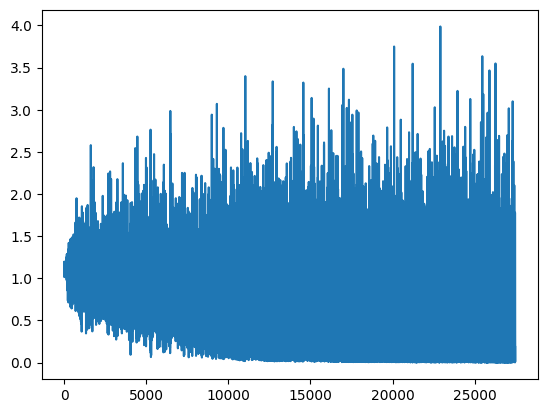

In [14]:
losses = []

prep_model(model_camera, is_camera=True)
plt.plot(losses)

# Submission

In [ ]:
dataset_test = MovementDataset(f"{root_path}/test_data.csv")

def collate_test(batch):
    # batch: list of [seq_len x 75] tensors
    data_list, lengths = zip(*batch)
    lengths = torch.tensor(lengths, dtype=torch.long) # (B,)
    data_padded = pad_sequence(data_list, batch_first=True)  # (B, max_seq, 75)
    return data_padded, lengths

test_loader = DataLoader(
    dataset_test,
    batch_size=64,
    shuffle=False,
    collate_fn=collate_test
)

In [16]:
df_test = pd.read_csv(f"{root_path}/test_data.csv")
ids = df_test["IDSample"].unique()

In [17]:
subtask1_ans = []
for i in range(len(ids)):
    subtask1_ans.append(dataset_test.len_frames(i))

In [18]:
subtask2_ans, subtask3_ans = [], []

model_action.eval()
model_action.eval()
with torch.no_grad():
    for data, lengths in tqdm(test_loader):
        # move to device
        data, lengths = data.to(device), lengths.to(device)

        # forward once
        logits_cam = model_camera(data, lengths)
        logits_act = model_action(data, lengths)

        # softmax -> probabilities
        probs_act = F.softmax(logits_act, dim=-1)  # shape (B,5)
        probs_cam = F.softmax(logits_cam, dim=-1)  # shape (B,3)

        # argmax -> class indices
        batch_pred_act = probs_act.argmax(dim=1).cpu().tolist()      # 0–4
        batch_pred_cam = (probs_cam.argmax(dim=1) + 1).cpu().tolist()# 1–3

        subtask2_ans.extend(batch_pred_act)
        subtask3_ans.extend(batch_pred_cam)

100%|██████████| 345/345 [00:05<00:00, 65.28it/s]


In [19]:
subtask1 = pd.DataFrame({
    "datapointID": ids,
    "answer": subtask1_ans,
    "subtaskID": 1
})

subtask2 = pd.DataFrame({
    "datapointID": ids,
    "answer": subtask2_ans,
    "subtaskID": 2
})

subtask3 = pd.DataFrame({
    "datapointID": ids,
    "answer": subtask3_ans,
    "subtaskID": 3
})

In [20]:
submission = pd.concat([subtask1, subtask2, subtask3])
submission.head()

,datapointID,answer,subtaskID
0,3361,124,1
1,3362,78,1
2,3363,207,1
3,3364,66,1
4,3365,83,1


In [21]:
submission.to_csv("submission.csv", index=False)